In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "browser"

In [2]:
REGION_CONFIG = {
    "US": {
        "description": "US Equities",
        "market_index": "^GSPC",
        "factors": {
            "Market": "^GSPC",
            "Value": "IWD",
            "Growth": "IWF",
            "Momentum": "MTUM",
            "LowVol": "SPLV",
        },
    },
    "India": {
        "description": "Indian Equities (NSE/BSE)",
        "market_index": "^NSEI",
        "factors": {
            "Market": "^NSEI",
        },
    },
}

In [3]:
# Infer
def infer_region_from_ticker(ticker: str) -> str:
    ticker = ticker.upper().strip()
    if ticker.endswith(".NS") or ticker.endswith(".BO"):
        return "India"
    return "US"

In [4]:
def download_price_series(ticker: str, start: str, end: str) -> pd.Series:
    """
    ALWAYS returns a pandas Series of closing prices.
    Index = dates, Values = prices.
    """
    data = yf.download(
        ticker,
        start=start,
        end=end,
        auto_adjust=True,
        progress=False
    )

    if data.empty:
        raise ValueError(f"No data returned for ticker: {ticker}")

    # FORCE Series output (this is the critical line)
    prices = data.loc[:, "Close"]

    if isinstance(prices, pd.DataFrame):
        # Safety fallback (should never happen, but we guard anyway)
        prices = prices.iloc[:, 0]

    return prices.dropna()


In [5]:
def compute_log_returns(price_series: pd.Series) -> pd.Series:
    returns = np.log(price_series / price_series.shift(1))
    return returns.dropna()


In [6]:
# DataFrame
def build_engineered_factors(
    stock_prices: pd.Series,
    market_prices: pd.Series
):
    df = pd.DataFrame({
        "Stock": stock_prices,
        "Market": market_prices
    }).dropna()

    returns = np.log(df / df.shift(1)).dropna()

    factors = pd.DataFrame(index=returns.index)

    # 1. Market factor
    factors["Market"] = returns["Market"]

    # 2. Momentum (6-month rolling mean return)
    factors["Momentum"] = returns["Stock"].rolling(126).mean()

    # 3. Volatility (6-month rolling std)
    factors["Volatility"] = returns["Stock"].rolling(126).std()

    # 4. Trend (rolling regression slope)
    window = 126
    trend_values = []

    for i in range(window, len(returns)):
        y = returns["Stock"].iloc[i-window:i]
        x = np.arange(window)
        beta = np.polyfit(x, y, 1)[0]
        trend_values.append(beta)

    trend = pd.Series(
        trend_values,
        index=returns.index[window:]
    )

    factors["Trend"] = trend

    # 5. Mean Reversion (price z-score)
    rolling_mean = df["Stock"].rolling(126).mean()
    rolling_std = df["Stock"].rolling(126).std()
    factors["MeanReversion"] = (df["Stock"] - rolling_mean) / rolling_std

    factors = factors.dropna()
    stock_returns = returns.loc[factors.index, "Stock"]

    return factors, stock_returns


In [7]:
# Core Factor Model Logic
def run_factor_regression(
    stock_returns: pd.Series,
    factor_returns: pd.DataFrame
):
    data = pd.concat([stock_returns, factor_returns], axis=1).dropna()

    y = data.iloc[:, 0]      # stock returns
    X = data.iloc[:, 1:]     # factor returns
    X = sm.add_constant(X)   # adds alpha

    model = sm.OLS(y, X).fit()

    alpha = model.params["const"]
    betas = model.params.drop("const")

    return {
        "alpha": alpha,
        "betas": betas,
        "r2": model.rsquared,
        "model": model,
        "data": data
    }


In [8]:
# Rolling Betas
def compute_rolling_betas(
    stock_returns: pd.Series,
    factor_returns: pd.DataFrame,
    window: int = 126
) -> pd.DataFrame:

    data = pd.concat([stock_returns, factor_returns], axis=1).dropna()
    betas_list = []
    dates = []

    for i in range(window, len(data)):
        window_data = data.iloc[i-window:i]
        y = window_data.iloc[:, 0]
        X = window_data.iloc[:, 1:]
        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit()
        betas_list.append(model.params.drop("const"))
        dates.append(window_data.index[-1])

    return pd.DataFrame(betas_list, index=dates)


In [9]:
# Visualization

def plot_price_vs_market(stock_prices, market_prices, stock_name, market_name):
    df = pd.concat([stock_prices, market_prices], axis=1)
    df.columns = [stock_name, market_name]
    df = df / df.iloc[0]

    df.plot(figsize=(10,5), title="Normalized Price Comparison")
    plt.grid(True)
    plt.show()

def plot_factor_bar(betas: pd.Series):
    betas.plot(kind="bar", figsize=(8,4), title="Factor Exposures (Betas)")
    plt.grid(axis="y")
    plt.show()

def plot_factor_radar(betas: pd.Series):
    factors = betas.index.tolist()
    values = betas.values.tolist()

    factors.append(factors[0])
    values.append(values[0])

    fig = go.Figure(
        data=go.Scatterpolar(
            r=values,
            theta=factors,
            fill="toself"
        )
    )

    fig.update_layout(
        title="Factor Exposure Radar",
        polar=dict(radialaxis=dict(visible=True))
    )

    fig.show()

def plot_rolling_betas(rolling_betas: pd.DataFrame):
    rolling_betas.plot(figsize=(10,5), title="Rolling Factor Betas")
    plt.grid(True)
    plt.show()


In [10]:
# Pipeline

def analyze_stock(
    ticker: str,
    start: str,
    end: str
):
    region = infer_region_from_ticker(ticker)
    market_ticker = REGION_CONFIG[region]["market_index"]

    stock_prices = download_price_series(ticker, start, end)
    market_prices = download_price_series(market_ticker, start, end)

    factors, stock_returns = build_engineered_factors(
        stock_prices,
        market_prices
    )

    result = run_factor_regression(stock_returns, factors)

    print(result["model"].summary())

    plot_factor_bar(result["betas"])
    plot_factor_radar(result["betas"])

    rolling_betas = compute_rolling_betas(stock_returns, factors)
    plot_rolling_betas(rolling_betas)

    return result


In [11]:
ticker = input("Enter stock ticker (e.g. RELIANCE.NS, TCS.NS, AAPL): ").strip()
start_date = input("Start date (YYYY-MM-DD): ").strip()
end_date = input("End date (YYYY-MM-DD): ").strip()

if not start_date:
    start_date = "2022-01-01"
if not end_date:
    end_date = "2025-01-01"


                            OLS Regression Results                            
Dep. Variable:                  Stock   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     304.5
Date:                Sun, 11 Jan 2026   Prob (F-statistic):          3.66e-206
Time:                        23:38:26   Log-Likelihood:                 3431.4
No. Observations:                1131   AIC:                            -6851.
Df Residuals:                    1125   BIC:                            -6821.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0062      0.001     -4.317

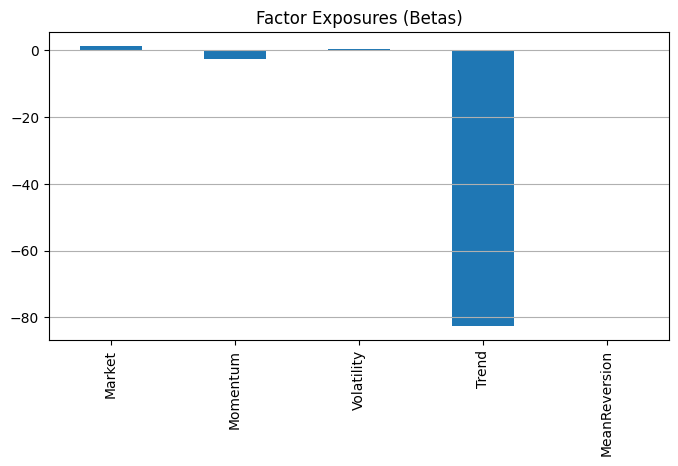

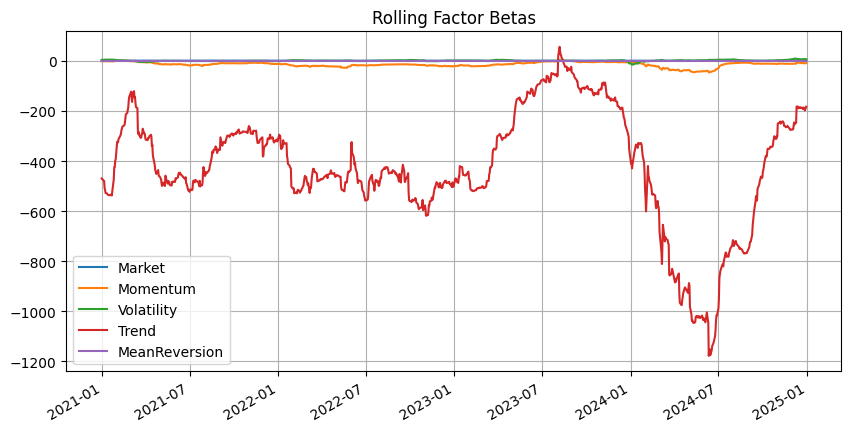

{'alpha': np.float64(-0.0062045543164042545),
 'betas': Market            1.216717
 Momentum         -2.734895
 Volatility        0.306663
 Trend           -82.596874
 MeanReversion     0.005144
 dtype: float64,
 'r2': np.float64(0.5750849754928582),
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x208cc36e7b0>,
 'data':                Stock    Market  Momentum  Volatility     Trend  MeanReversion
 Date                                                                         
 2020-07-06  0.026399  0.015757  0.001855    0.033332  0.000071       2.097213
 2020-07-07 -0.003108 -0.010877  0.001768    0.033330  0.000076       2.011855
 2020-07-08  0.023023  0.007797  0.001988    0.033378  0.000076       2.201303
 2020-07-09  0.004291 -0.005660  0.001895    0.033356  0.000082       2.186367
 2020-07-10  0.001748  0.010412  0.001742    0.033311  0.000088       2.147319
 ...              ...       ...       ...         ...       ...            ...
 2024-12-24  0.011

In [12]:
analyze_stock(
    ticker=ticker,
    start=start_date,
    end=end_date
)
